<a href="https://colab.research.google.com/github/asylunatic/unet/blob/master/Reproducability_Project_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports & Installs

In [90]:
!pip install torch torchvision
!pip install -q elasticdeform

import torch
torch.manual_seed(0)

import torch.optim as optim
import torchvision.transforms as transforms

from torch.utils.data import DataLoader, Dataset
from torch import nn

import os
import time
import math


import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

import numpy as np
np.random.seed(1)


from PIL import Image
from pathlib import Path

from typing import Tuple

from google.colab import drive

# Download Dataset

To download a dataset from Kaggle, you need a `kaggle.json` file that contains your Kaggle credentials. The `kaggle.json` file can be downloaded from the website under Account > Create new API token. Then `KAGGLE_CONFIG_DIR` should point to the directory that contains the `kaggle.json`. 

In [0]:
def download_data(tiny_normal: bool, tiny_rotated: bool, large_normal: bool):
  """Download the different datasets. All datasets are augmented in some way.
  
  Params
  ------
  tiny_normal: bool
    150 images, elastic deform, no rotation

  tiny_rotated: bool
    150 images, elastic deform, with rotation

  large_normal: bool
    1500 images, elastic deform, no rotation
  """

  os.environ['KAGGLE_CONFIG_DIR'] = "/content/"

  if tiny_normal and not Path('/content/rotated-tiny-augmented-segmentation-challenge-data.zip').exists():
    !kaggle datasets download sranjha/rotated-tiny-augmented-segmentation-challenge-data
    !unzip -q /content/rotated-tiny-augmented-segmentation-challenge-data.zip -d rotated-tiny-augmented-segmentation-challenge-data
  
  if tiny_rotated and not Path('/content/split-tiny-augmented-segmentation-challenge-data.zip').exists():
    !kaggle datasets download sranjha/split-tiny-augmented-segmentation-challenge-data
    !unzip -q /content/split-tiny-augmented-segmentation-challenge-data.zip -d split-tiny-augmented-segmentation-challenge-data
  
  if large_normal and not Path('/content/50x-augmented-segmentation-challenge-data.zip').exists():
    !kaggle datasets download sranjha/50x-augmented-segmentation-challenge-data
    !unzip -q /content/50x-augmented-segmentation-challenge-data.zip -d 50x-augmented-segmentation-challenge-data

# Network Architecture

## Utility methods


In [0]:
def center_crop_feature_map(feature_map: torch.Tensor, target_tensor: torch.Tensor) -> torch.Tensor:
  """Center crop a feature map in the x, y dimension to match the size of the 
  target tensor.
  
  Params
  ------
  feature_map: torch.Tensor
    an 1 x 1 x H x W tensor representing a feature map

  target_tensor: torch.Tensor
    an 1 x 1 x H_crop x W_crop tensor whose size should be matched

  Returns
  -------
  torch.Tensor
    the feature_map center cropped to 1 x 1 x H_crop x W_crop

  """
 
  _, _, feature_map_height, feature_map_width = feature_map.size()
  _, _, target_height, target_width = target_tensor.size()
  diff_y = (feature_map_height - target_height) // 2
  diff_x = (feature_map_width - target_width) // 2

  
  return feature_map[
          :, :, diff_y: (diff_y + target_height), diff_x: (diff_x + target_width)
          ]

def center_crop_image_tensor(in_tensor: torch.Tensor, target_dim: Tuple[int, int]) -> torch.Tensor:
  """Center crop an image tensor in the x, y dimension to match the target
  dimensions.

  Params
  ------
  in_tensor: torch.Tensor
    a 1 x H x W tensor representing an image

  target_dim: Tuple[int, int]
    contains the target dimensions, H_crop and W_crop

  Returns
  -------
  torch.Tensor
    the in_tensor center cropped to 1 x H_crop x W_crop

  """

  _, input_height, input_width = in_tensor.size()

  diff_y = (input_height - target_dim[0]) // 2
  diff_x = (input_width - target_dim[1]) // 2


  return in_tensor[:, diff_y : diff_y + target_dim[0], diff_x : diff_x + target_dim[1]]

def get_loss(data_loader: DataLoader, net: nn.Module, criterion) -> float:
  """Get average loss on the data in the given dataloader.
  
  Params
  ------
  data_loader: DataLoader
    has the data over which the loss should be computed

  net: nn.Module
    neural net that produces an output

  criterion: 
    loss function

  """
  running_loss = 0
  for (image, label) in data_loader:
    image = image.cuda(0)
    label = label.cuda(0)
    out = net(image)

    _,_,oh,ow = out.size()
      
    label = center_crop_image_tensor(label, (oh, ow))
      

    loss = criterion(out, label)
    running_loss += loss.item()
  return running_loss / len(data_loader)

def plot_learning_curve(train_losses: list, test_losses: list, title: str, save_plot = False):
  iterations = range(0, len(train_losses))
  plt.figure(figsize=(20,15))
  plt.plot(iterations, train_losses, label= "train")
  plt.plot(iterations, test_losses, label= "test")
  plt.title(title)
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  if save_plot:
    plt.savefig(f"/content/drive/My Drive/{title}.png")
  plt.show()

## Network

In [0]:
def conv(kernel_size: int, in_channels: int, out_channels: int) -> nn.Conv2d:
  """Create a 2d convolutional layer.
  
  Params
  ------
  kernel_size: int
    the kernel will have size (kernel_size x kernel_size)

  in_channels: int
    the number input feature maps

  out_channels: int
    the number of output feature maps

  Returns
  -------
  Conv2d
    a kernel_size x kernel_size convolutional layer
  """

  return nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=0)

def conv_activate(in_channels: int, out_channels: int, init_method) -> nn.Sequential:
  """Two 3x3 convolutions followed by relus.
  
  Params
  ------
  in_channels: int
    number of input feature maps for the first convolution

  out_channels: int
    number of input maps for the second convolution; number of output feature 
    maps for both convolutions

  Returns
  -------
  nn.Sequential
    sequence of a 3x3 convolution, relu, 3x3 convolution, relu
  """
  c1 = conv(3, in_channels, out_channels)
  c2 = conv(3, out_channels, out_channels)

  if init_method == 'xavier':
    torch.nn.init.xavier_normal_(c1.weight) 
    torch.nn.init.xavier_normal_(c2.weight) 
  elif init_method == 'kaiming':
    torch.nn.init.kaiming_normal_(c1.weight)
    torch.nn.init.kaiming_normal_(c2.weight)
  else:
    raise ValueError(f"Invalid weight initialization method {init_method}.")
    
  return nn.Sequential(
      c1,
      nn.ReLU(),
      c2,
      nn.ReLU())

class Contraction(nn.Module):
  """Class representing one step in the contracting path.
  
  One step consists of two 3x3 convolutions, each followed by a relu. These
  convolutions/relus are then followd by a max pooling operation. Both the 
  result from the convs/relus and the max pooling are returned, as the former
  is needed for the expanding path, and the latter for continuing the 
  contracting path.
  """

  def __init__(self, in_channels: int, out_channels: int, init_method: str):
    super(Contraction, self).__init__()
    
    self.conv_activate = conv_activate(in_channels, out_channels, init_method)
    self.maxpool = nn.MaxPool2d(2)
   
  def forward(self, x):
    x = self.conv_activate(x) 
    mp = self.maxpool(x)

    return mp, x
    
class Expansion(nn.Module):
  """Class representing one step in the expanding path.

  One step consists of either:
    1. An upsampling followed by a 2x2 convolution.
    2. A 2x2 transpose convolution.

    Both of these act on the output from the previous layer concatenated
    with the feature map from the corresponding layer in the contracting path.

  Followed by two 3x3 convolutions, each followed by a relu.
  """

  def __init__(self, in_channels: int, out_channels: int, up_method: str, init_method: str):
    super(Expansion, self).__init__()
    
    if up_method == 'upsample':
      self.up2x2 = nn.Sequential(
          nn.Upsample(scale_factor=2, mode = 'nearest'), # mode is nearest to match keras' default
          conv(2, in_channels, out_channels)
      )
    elif up_method == 'transpose':
      self.up2x2 = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
    else:
      print("Invalid upconvolution method.")

    self.conv_activate = conv_activate(in_channels, out_channels, init_method)

  def forward(self, x, fm):
    """
    Params
    ------
    fm
      feature map from the corresponding layer in the contracting path
    """
    
    x = self.up2x2(x)

    # concatenate the previously extracted feature map with the upsampled map
    fm = center_crop_feature_map(fm, x)
    x = torch.cat([fm, x], dim=1)  
    x = self.conv_activate(x)
      
    return x


class UNet(nn.Module):
  def __init__(self, num_classes: int, up_method = 'upsample', init_method = 'kaiming'):
    super(UNet, self).__init__()    

    self.contraction1 = Contraction(1, 64, init_method)
    self.contraction2 = Contraction(64, 128, init_method)
    self.contraction3 = Contraction(128, 256, init_method)
    self.contraction4 = Contraction(256, 512, init_method)

    self.bottomlayer = Contraction(512, 1024, init_method)
    
    self.expansion4 = Expansion(1024, 512, up_method, init_method)
    self.expansion3 = Expansion(512, 256, up_method, init_method)
    self.expansion2 = Expansion(256, 128, up_method, init_method)
    self.expansion1 = Expansion(128, 64, up_method, init_method)
        
    self.map_to_classes = conv(1, 64, num_classes)
    if init_method == 'xavier':
      torch.nn.init.xavier_normal_(self.map_to_classes.weight)
    elif init_method == 'kaiming':
      torch.nn.init.kaiming_normal_(self.map_to_classes.weight)
    else:
      raise ValueError(f"Invalid weight initialization method {init_method}.")
    

  def forward(self, x):
    feature_maps = []

    x, fm = self.contraction1(x)
    feature_maps.append(fm)
    x, fm = self.contraction2(x)
    feature_maps.append(fm)    
    x, fm = self.contraction3(x)
    feature_maps.append(fm)
    x, fm = self.contraction4(x)
    feature_maps.append(fm)

    
    _, x = self.bottomlayer(x)
    
    
    x = self.expansion4(x, feature_maps[3])   
    x = self.expansion3(x, feature_maps[2])
    x = self.expansion2(x, feature_maps[1])
    x = self.expansion1(x, feature_maps[0])

    x = self.map_to_classes(x)
    return x

## Dataset


In [0]:
class UnetDataset(Dataset):
  """Unet dataset."""

  def __init__(self, image_dir: str, label_dir: str):#, label_dim: int):
    """
    Params
    ------
    image_dir: str
      directory with the original images
    
    label_dir: str
      directory with the ground truth segmentations
    """

    self.image_dir = Path(image_dir)
    self.label_dir = Path(label_dir)

  def __len__(self):
    return len(list(self.image_dir.glob("*.tif")))

  def __getitem__(self, idx):
    image_list = list(self.image_dir.glob("*.tif"))
    image_path = image_list[idx]
    label_path = self.label_dir.joinpath(image_path.name.replace("train", "label").replace("test", "label"))
    
    image = Image.open(image_path)
    image = transforms.ToTensor()(image)  

    label = Image.open(label_path)
    label = transforms.ToTensor()(label)
    label = label.long()
    _, lh, lw = label.size()
    label = torch.reshape(label, (lh, lw))

    return (image, label)

## Training method


In [0]:
def plot_learning_curve(train_losses: list, test_losses: list, title: str, save_plot = False, save_dir = None):
  """Plots and shows training vs. test losses.
  The number of train losses should be equal to the number of test losses.

  Params
  ------
  train_losses: list
    training losses as floating point values
  
  train_losses: list
    test losses as floating point values

  title: str
    title of the plot

  save_plot: bool
    whether or not the plot should be saved

  """
  iterations = range(0, len(train_losses))
  plt.figure(figsize=(20,15))
  plt.plot(iterations, train_losses, label= "train")
  plt.plot(iterations, test_losses, label= "test")
  plt.title(title)
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  if save_plot:
    if save_dir is not None:
      plt.savefig(f"{save_dir}{title}.png")
    else:
      print("No save directory provided. Curve was not saved.")
  plt.show()

In [0]:
def train_unet(train_loader: DataLoader, test_loader: DataLoader, 
               up_method = 'upsample', init_method='kaiming', num_classes = 2, 
               num_epochs = 100, logging_mode = 'fine',
               logging_interval = 25, early_stop_patience = 5, early_stop_treshold = 1e-3,
               plot_curve: bool = True, save_model: bool = True, save_dir: str = None) -> (UNet, list, list):
  
  if save_model and save_dir is None:
    print("Model is supposed to be saved, but no save directory was provided.")
    print("No training will take place.")
    return
  
  print("Started.")
  net: UNet = UNet(num_classes=num_classes, up_method=up_method, init_method=init_method)
  net.train()
  net.cuda(0)

  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(net.parameters(), lr= 0.01, momentum=0.99)
  scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, min_lr = 1e-5)
  

  train_losses = []
  test_losses = []
  min_loss = float("inf")
  early_stop_timer = 0
  stopping_epoch = 0
  for epoch in range(num_epochs):
    stopping_epoch = epoch + 1
    running_loss = 0.0
    e_start = time.time()
    for i, (image, label) in enumerate(train_loader):      
      image = image.cuda(0)
      label = label.cuda(0)

      output = net(image)
      _, _, oh, ow = output.size()
      
      label = center_crop_image_tensor(label, (oh, ow))
      loss = criterion(output, label)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()    

      running_loss += loss.item()
      
      if i % logging_interval == logging_interval - 1:
        if logging_mode == "fine":
          print(f'[{epoch + 1}, {i + 1}] loss: {running_loss/logging_interval}')
        if plot_curve:  
          train_losses.append(running_loss/logging_interval)
        running_loss = 0.0
        
        if plot_curve:
          net.eval()
          test_loss = get_loss(test_loader, net, criterion)
          test_losses.append(test_loss)
          net.train()

    if logging_mode == 'fine' or logging_mode == 'coarse':  
      print(f'[{epoch + 1}/{num_epochs}] completed in {time.time() - e_start} seconds')  

    net.eval()
    epoch_test_loss = get_loss(test_loader, net, criterion)
    net.train()
    scheduler.step(epoch_test_loss)

    if min_loss - epoch_test_loss > early_stop_treshold:
      if logging_mode == "fine":
        print(f"Loss diff {min_loss - epoch_test_loss} larger than treshold {early_stop_treshold}.")
      min_loss = epoch_test_loss
      early_stop_timer = 0
    else:
      early_stop_timer += 1
      if logging_mode == "fine":
        print(f"Loss diff {min_loss - epoch_test_loss} smaller than treshold {early_stop_treshold}.")
        print(f"Early stop timer increased to {early_stop_timer}.")
    if early_stop_timer >= early_stop_patience:
      break
    if save_model:
      checkpoint = { 
        'epoch': epoch,
        'model': net.state_dict(),
        'optimizer': optimizer.state_dict(),
        'lr_sched': scheduler.state_dict()}
      torch.save(checkpoint, f'{save_dir}/checkpoint_{up_method}_{init_method}_{num_epochs}_{len(train_loader)}.pth')

  if logging_mode == 'fine' or logging_mode == 'coarse':
    print(f"Stopped training after {stopping_epoch} epochs.")

  if save_model:
    torch.save(net.state_dict(), f'{save_dir}/model_{up_method}_{init_method}_{num_epochs}_{stopping_epoch}_{len(train_loader)}.pth')
    print(f"Saved model to {save_dir}/model_{up_method}_{init_method}_{num_epochs}_{stopping_epoch}_{len(train_loader)}.pth")

  if plot_curve:
    plot_learning_curve(train_losses, test_losses, f"{up_method}_{init_method}_{num_epochs}_{stopping_epoch}_{len(train_loader)}", save_plot=True, save_dir = save_dir)
  
  return net, train_losses, test_losses



## Actually train the network!


### Download the data

We mount our Google Drive, because this is where we would like to save/load trained models and images.

In [97]:
download_data(True, True, False)
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Define the dataloaders

**Small training and validation dataloader**

Load the small rotated dataset and split it into a training and a validation set. The training set is used for training, and the validation set for intermediate validation, i.e. to determine when the model starts to overfit.

In [0]:
small_dpath = "/content/split-tiny-augmented-segmentation-challenge-data/train_5x"
small_labels_dpath = "/content/split-tiny-augmented-segmentation-challenge-data/train_labels_5x"

small_dataset = UnetDataset(small_dpath, small_labels_dpath)
small_training_set, small_val_set = torch.utils.data.random_split(small_dataset, [math.floor(0.8 * len(small_dataset)), math.ceil(0.2 * len(small_dataset))])

small_train_loader = DataLoader(small_training_set, batch_size = 1, pin_memory = True)
small_val_loader = DataLoader(small_val_set, batch_size = 1, pin_memory = True)

**Small rotated training and validation dataloader**

Load the small rotated dataset and split it into a training and a validation set.

In [0]:
small_rotated_dpath = "/content/rotated-tiny-augmented-segmentation-challenge-data/train_5x"
small_rotated_labels_dpath = "/content/rotated-tiny-augmented-segmentation-challenge-data/train_labels_5x"

small_rotated_dataset = UnetDataset(small_rotated_dpath, small_rotated_labels_dpath)
small_rotated_training_set, small_rotated_val_set = torch.utils.data.random_split(small_rotated_dataset, [math.floor(0.8 * len(small_rotated_dataset)), math.ceil(0.2 * len(small_rotated_dataset))])

small_rotated_train_loader = DataLoader(small_rotated_training_set, batch_size = 1, pin_memory = True)
small_rotated_val_loader = DataLoader(small_rotated_val_set, batch_size = 1, pin_memory = True)

**Large training and validation dataloader**

Load the large dataset and split it into a training and a validation set.

In [0]:
large_dpath = "/content/50x-augmented-segmentation-challenge-data/train_50x"
large_labels_dpath = "/content/50x-augmented-segmentation-challenge-data/train_labels_50x"

large_dataset = UnetDataset(large_dpath, large_labels_dpath)
large_training_set, large_val_set = torch.utils.data.random_split(large_dataset, [math.floor(0.8 * len(large_dataset)), math.ceil(0.2 * len(large_dataset))])

large_train_loader = DataLoader(large_training_set, batch_size = 1, pin_memory = True)
large_val_loader = DataLoader(large_val_set, batch_size = 1, pin_memory = True)

### Train the network

You can choose what training and validation data to use, as well as which upsampling method and which initialisation method. Please note that 'upsample' only works with 'xavier' initialization. On the other hand, 'transpose' work with both 'xavier' and 'kaiming' initialization.

We use the small rotated augmented dataset because it offers a good tradeoff between number of images and training time, and because it includes both rotated and non-rotated images.

In [0]:
train_loader = small_rotated_train_loader
val_loader = small_rotated_val_loader
save_dir = "/content/drive/My Drive/models"

**Small rotated dataset, Xavier initialization, upsample upsampling**

In [0]:
small_net_up_xa, small_trloss_up_xa, small_tloss_up_xa = train_unet(train_loader, val_loader, up_method = 'upsample', init_method='xavier', save_dir = save_dir, early_stop_patience=15)

Started.
[1, 25] loss: 0.6077567529678345
[1, 50] loss: 0.5467431390285492
[1, 75] loss: 0.46701841950416567
[1, 100] loss: 0.4941413354873657
[1, 125] loss: 0.5087906861305237
[1, 150] loss: 0.48531694412231446
[1, 175] loss: 0.49989427089691163
[1, 200] loss: 0.4373620891571045
[1/100] completed in 422.8961021900177 seconds
Loss diff inf larger than treshold 0.001.
[2, 25] loss: 0.45961405634880065
[2, 50] loss: 0.4413933002948761
[2, 75] loss: 0.43994797348976133
[2, 100] loss: 0.46190872430801394
[2, 125] loss: 0.4612396490573883
[2, 150] loss: 0.4487589085102081
[2, 175] loss: 0.46905665755271914


**Small rotated dataset, Xavier initialization, transpose upsampling**

In [0]:
small_net_tr_ka, small_trloss_tr_ka, small_tloss_tr_ka = train_unet(train_loader, val_loader, up_method = 'transpose', init_method='kaiming', save_dir = save_dir, early_stop_patience=15)

**Small rotated dataset, Kaiming initialization, transpose upsampling**

In [0]:
small_net_tr_xa, small_trloss_tr_xa, small_tloss_tr_xa = train_unet(small_train_loader, small_val_loader, up_method = 'transpose', init_method='xavier', save_dir = save_dir,, early_stop_patience=15)

## Evaluate the network

## Evaluation Methods



In [0]:
def true_false_pos_neg(output: np.ndarray, label: np.ndarray, threshold: float):
  output[output > threshold] = 1
  output[output <= threshold] = 0

  true_pos = np.sum((output == label) & (output == 1))
  false_pos = np.sum((output != label) & (output == 1))
  true_neg = np.sum((output == label) & (output == 0))
  false_neg = np.sum((output != label) & (output == 0))

  return true_pos, false_pos, true_neg, false_neg

def f_score(output: np.ndarray, label: np.ndarray, threshold: float):
  true_pos, false_pos, true_neg, false_neg = true_false_pos_neg(output, label, threshold)

  precision, recall, fscore = 0, 0, 0

  if false_pos == 0 : 
    precision = 1
  else:  
    precision = true_pos / (true_pos + false_pos)

  if false_neg == 0:
    recall = 1
  else:
    recall = true_pos / (true_pos + false_neg)

  if precision + recall > 0:
    fscore = 2 * precision * recall / (precision + recall)  
  return fscore

def best_f_score(output, label):
  thresholds = np.linspace(0,1,11)
  best_f = 0

  for thr in thresholds:
    new_f = f_score(output, label, thr)
    if new_f > best_f:
      best_f = new_f
  return best_f

def pixel_error(output, label):
  best_f = best_f_score(output.copy(), label)
  return 1 - best_f


def naive_pixel_error(output: np.ndarray, label: np.ndarray):
  """Calculates the percentage of pixels that were NOT correctly classified.

  Params
  ------
  output: np.ndarray
    a 2-dimensional integer array in which the background pixels are labeled with a 1
    representing the predicted labels

  label: np.ndarray
    a 2-dimensional integer array in which the background pixels are labeled with a 1
    representing the true labels
  
  """

  return np.sum(output != label)/output.size

def intersection_over_union(predicted: np.ndarray, label: np.ndarray):
  """Calculates the intersection over union of the output and the true label.

  Params
  ------
  predicted: np.ndarray
    a 2-dimensional integer array in which the background pixels are labeled 
    with a 1; represents the predicted labels

  label: np.ndarray
    a 2-dimensional integer array in which the background pixels are labeled 
    with a 1; represents the true labels
  
  """
  
  intersection = (predicted & label).sum((0,1))
  union = (predicted | label).sum((0,1))
  return intersection / union


def binary_mask(image: np.ndarray, chan = 1):
  """Apply mask to image. Every value over 0.5 becomes a 1, every value
  under 0.5 becomes a 0.
  
  Params
  ------
  image: np.ndarray
    a H X W X C image; H is height, W is width, C is channels (assumed to be 2)

  chan: int
    whether the correct labelings can be found in channel 0 or 1
  """

  masked = image[:,:,chan]
  masked[masked < 0.5] = 0
  masked[masked >= 0.5] = 1
  return masked.astype('int')

def argmax_mask(image: np.ndarray):
  """Apply mask to an image. Finds the index of the channel with the largest
  value.

  Params
  ------
  image: np.ndarray
    H X W X C image
    H is the height, W the width, C the number of channels
  """
  return np.argmax(image, axis=2)



### Define test dataloaders

These load data that was held out completely, i.e. was not used in training or intermediate validation.

**Small test dataloader**


In [0]:
small_test_dpath = "/content/split-tiny-augmented-segmentation-challenge-data/test_5x"
small_test_labels_dpath = "/content/split-tiny-augmented-segmentation-challenge-data/test_labels_5x"

small_test_dataset = UnetDataset(small_test_dpath, small_test_labels_dpath)
small_test_dataloader = DataLoader(small_test_dataset, batch_size = 1, pin_memory = True)

**Small rotated test dataloader**

In [0]:
small_rotated_test_dpath = "/content/rotated-tiny-augmented-segmentation-challenge-data/test_5x"
small_rotated_test_labels_dpath = "/content/rotated-tiny-augmented-segmentation-challenge-data/test_labels_5x"

small_rotated_test_dataset = UnetDataset(small_rotated_test_dpath, small_rotated_test_labels_dpath)
small_rotated_test_dataloader = DataLoader(small_rotated_test_dataset, batch_size = 1, pin_memory = True)

**Large test dataloader**

In [0]:
large_test_dpath = "/content/50x-augmented-segmentation-challenge-data/test_50x"
large_test_labels_dpath = "/content/50x-augmented-segmentation-challenge-data/test_labels_50x"

large_test_dataset = UnetDataset(large_test_dpath, large_test_labels_dpath)
large_test_dataloader = DataLoader(large_test_dataset, batch_size = 1, pin_memory = True)

## Load network

If you trained a network earlier in this notebook you don't need to load one, but if you want to, this is where you can do it!

In [70]:
up_xa_net = UNet(num_classes=2, up_method='upsample', init_method='xavier')
up_xa_net.load_state_dict(torch.load("/content/drive/My Drive/models/model_upsample_xavier_100_48_216.pth"))
up_xa_net.cuda(0)
print()

In [71]:
tr_ka_net = UNet(num_classes=2, up_method='transpose', init_method='kaiming')
tr_ka_net.load_state_dict(torch.load("/content/drive/My Drive/models/model_transpose_kaiming_100_23_216.pth"))
tr_ka_net.cuda(0)
print()

In [72]:
net = UNet(num_classes=2, up_method='transpose', init_method='xavier')
net.load_state_dict(torch.load("/content/drive/My Drive/models/model_transpose_xavier_100_62_108.pth"))
net.cuda(0)
print()

### Get output



In [0]:
test_dataloader = small_rotated_test_dataloader

In [81]:
cropped_images = []
seg_images = []
masked_images = []
argmasked_images = []
cropped_labels = []

for i, (image, label) in enumerate(test_dataloader):      
  image = image.cuda(0)
  out = net(image)
  out = torch.nn.functional.softmax(out)
  out = out.cpu()

  ob, oc, oh, ow = out.size()

  out = out.reshape(oc, oh, ow).permute(1,2,0).detach().numpy()

  seg_images.append(out)
  masked_images.append(binary_mask(out))
  argmasked_images.append(np.argmax(seg_images[i], axis=2))
  cropped_labels.append(center_crop_image_tensor(label, (oh, ow)).reshape(oh, ow).detach().numpy())
  cropped_images.append(center_crop_image_tensor(image.cpu().reshape(1,700,700), (oh, ow)).reshape(oh, ow).detach().numpy())



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # Remove the CWD from sys.path while we load stuff.


### Evaluate


In [82]:
IOUs = []
naive_pixel_errors = []
pixel_errors = []

for i in range(0, len(cropped_labels)):
  IOUs.append(intersection_over_union(masked_images[i], cropped_labels[i]))
  naive_pixel_errors.append(naive_pixel_error(masked_images[i], cropped_labels[i]))
  pixel_errors.append(pixel_error(seg_images[i][:,:,1], cropped_labels[i]))

print(sum(IOUs)/len(IOUs))
print(sum(naive_pixel_errors)/len(naive_pixel_errors))
print(sum(pixel_errors)/len(pixel_errors))

0.837754336477677
0.12479578434614472
0.08851725073007703


### Plot images


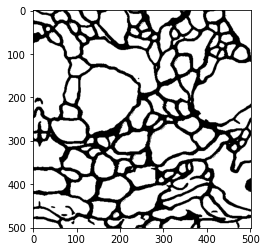

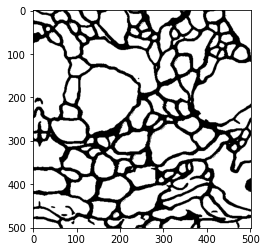

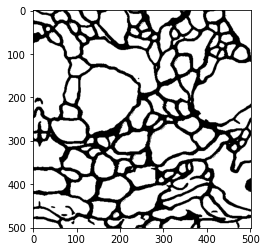

In [83]:
plt.imshow(seg_images[0][:,:,1], cmap='gray')
plt.show()

plt.imshow(argmasked_images[0], cmap='gray')
plt.show()

plt.imshow(masked_images[0], cmap= 'gray')
plt.show()